# Aufgabe 3 - Tiefe Einblicke ins Institut: Reloaded

Den Code immer nachvollziehbar kommentieren! Bitte beachtet, dass das Notebook von Anfang bis Ende ohne Fehler durchlaufen muss und dass die requirements.txt Datei aktualisiert wird. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F  
import torchvision.transforms as T
import torch.optim as optim
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

EARLY_STOP = False

## Teilaufgabe a): Trainings-, Test-und Validierungsdatenset

In [15]:
import os
import random
import math
import re
random.seed(322)

training_path_list = []     # Gleiche Liste aus Aufgabe 2
test_path_list = []         # Gleiche Liste aus Aufgabe 2
validation_path_list = []   # ["./pfad/zu/bildZ.png","./pfad/zu/bildY.png",...]


RE_FILE = re.compile(r"[a-zA-Z]+\d+\.jpg")


def create_data_split(folder, label: int, train_percent, test_percent, val_percent, base_only=True):
    """
    :param base_only: Only include base files, no augmented ones
    """

    assert train_percent + test_percent == 1, "train and test percentages dont add up to 1.0"
    assert 0 < val_percent <= 1, "validation percent must be within [0..1]"
    files = os.listdir(folder)
    if base_only:
        files = [f for f in files if RE_FILE.match(f)]
    random.shuffle(files)

    train_cnt = math.ceil(len(files) * train_percent)
    val_cnt = math.ceil(train_cnt * val_percent)
    train_files = [f'{folder}/{f}' for f in files[:train_cnt]]
    test_files = [f'{folder}/{f}' for f in files[train_cnt:]]
    valid_files = train_files[:val_cnt]

    random.shuffle(train_files)
    random.shuffle(test_files)
    random.shuffle(valid_files)

    return list(zip(train_files, [label] * len(train_files))), \
           list(zip(test_files, [label] * len(test_files))), \
           list(zip(valid_files, [label] * len(valid_files)))


def create_full_data_split(base_only=True):
    train_percent = 0.7
    test_percent = 0.3
    val_percent = 0.3

    flur_train, flur_test, flur_val = create_data_split('Bilder/Flur', 0, train_percent, test_percent, val_percent, base_only)
    labo_train, labo_test, labo_val = create_data_split('Bilder/Labor', 1, train_percent, test_percent, val_percent, base_only)
    prof_train, prof_test, prof_val = create_data_split('Bilder/Professorenbuero', 2, train_percent, test_percent, val_percent, base_only)
    teek_train, teek_test, teek_val = create_data_split('Bilder/Teekueche', 3, train_percent, test_percent, val_percent, base_only)


    train_files = flur_train + labo_train + prof_train + teek_train
    test_files  = flur_test + labo_test + prof_test + teek_test
    val_files   = flur_val + labo_val + prof_val + teek_val

    random.shuffle(train_files)
    random.shuffle(test_files)
    random.shuffle(val_files)

    train_batch_len = (len(train_files) // 16) * 16
    test_batch_len = (len(test_files) // 16) * 16
    val_batch_len = (len(val_files) // 16) * 16

    return (
        [f[0] for f in train_files][:train_batch_len],
        [f[1] for f in train_files][:train_batch_len],
        [f[0] for f in test_files][:test_batch_len],
        [f[1] for f in test_files][:test_batch_len],
        [f[0] for f in val_files][:val_batch_len],
        [f[1] for f in val_files][:val_batch_len],
    )



training_path_list, y_train, test_path_list, y_test, validation_path_list, y_val = create_full_data_split()

print('')


## Teilaufgabe b): CNN definieren und implementieren

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

## Teilaufgabe c): Training und Test mit CNN

Datenset-Klasse um mit Pytorch Bilder zu laden. 

Input sind: 
- Liste mit Pfaden zu Bildern
- Liste mit dazugehörigen Labels (numerisch darstellen!) 
- Transformation der Bilder


In [ ]:
class ROBDataset(Dataset):
    def __init__(self, img_path_list, img_labels, transform=None):
        # Pfade zu den Bildern als list
        self.img_path_list = img_path_list
        
        # Dazugehörige Labels zu den Bildern als list
        self.img_labels = img_labels
        
        # Transformations der Bilder
        self.transform = transform

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        # Bild laden
        img_path = self.img_path_list[idx]
        image = read_image(img_path)
        
        # Label laden
        label = self.img_labels[idx]
        
        # Transformieren
        if self.transform:
            image = self.transform(image)
            
        return image.float(), int(label)

Trainingsiteration über alle Bilder.

Inputs sind:
- Pytorch dataloader Object über das iteriert wird
- bool do_backprob Parameter um Backpropagation durchzuführen oder nicht

In [ ]:
from torchmetrics import Accuracy
def accuracy_score(output, labels):
    output = torch.from_numpy(output)
    labels = torch.from_numpy(labels)
    acc = Accuracy(task="multiclass", num_classes=4)
    r = acc(output, labels)
    return r

# Iterating over the entire data set once
def run_iteration(dataloader, do_backprob=True):
    global net, optimizer, criterion
    loss_iter = []
    acc_iter = []
    for batch_x, batch_y in dataloader:
        # To device
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        y_predict = net(batch_x)
        loss = criterion(y_predict, batch_y)
        if do_backprob:
            loss.backward()
            optimizer.step()

        # statistics
        loss_iter.append(loss.detach().cpu().numpy())
        
        _, predicted = torch.max(torch.softmax(y_predict, dim=1),1)
        
        acc_iter.append(accuracy_score(batch_y.detach().cpu().numpy(), 
                                       predicted.detach().cpu().numpy()))
    
    return np.mean(loss_iter), np.mean(acc_iter)

Komplette Durchführung eines Trainings
Die Variablen y_train, y_val und y_test müssen noch gesetzt werden. Diese Listen beinhalten die entsprechenden Labels als numerische Darstellung.

Running on  cpu
Train / test images: 208/80

Started Training
Epoch 1 from 100
	Train Loss	 1.380919
	Train Acc.	 0.25480768
	Val Loss	 1.22317
	Val Acc.	 0.296875
	Diff		 0.15774893760681152
Epoch 2 from 100
	Train Loss	 0.99998295
	Train Acc.	 0.6394231
	Val Loss	 0.53624254
	Val Acc.	 0.78125
	Diff		 0.46374040842056274
Epoch 3 from 100
	Train Loss	 0.4812887
	Train Acc.	 0.8269231
	Val Loss	 0.31356
	Val Acc.	 0.875
	Diff		 0.16772869229316711
Epoch 4 from 100
	Train Loss	 0.22714123
	Train Acc.	 0.9326923
	Val Loss	 0.23697928
	Val Acc.	 0.9375
	Diff		 0.0098380446434021
Epoch 5 from 100
	Train Loss	 0.09899921
	Train Acc.	 0.97115386
	Val Loss	 0.1638506
	Val Acc.	 0.921875
	Diff		 0.06485139578580856
Epoch 6 from 100
	Train Loss	 0.073871545
	Train Acc.	 0.97596157
	Val Loss	 0.023157299
	Val Acc.	 1.0
	Diff		 0.050714246928691864
Epoch 7 from 100
	Train Loss	 0.02023676
	Train Acc.	 0.9951923
	Val Loss	 0.0065831384
	Val Acc.	 1.0
	Diff		 0.013653622008860111
Epoch 8 from 100
	

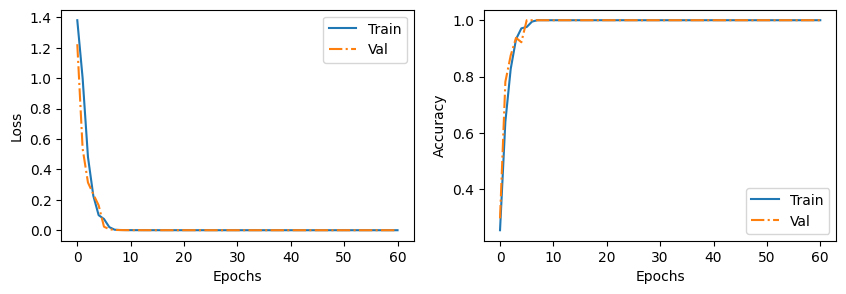

In [31]:
# Training settings - bei Bedarf anpassbar
max_epoch = 100
batch_size = 16
lr = 0.001
early_stop_cnt = 0
early_stop_min_delta = 0.000001
early_stop_tolerance = 5

# Transformations for dataloader
t_train = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_val = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_test = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# Where to do calculations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on ", device)
print(f'Train / test images: {len(training_path_list)}/{len(test_path_list)}')

# Training Data, NOTE: y_train labels need to be set
dataset_train = ROBDataset(training_path_list, y_train, transform=t_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Validation Data, NOTE: y_val labels need to be set
dataset_val = ROBDataset(validation_path_list, y_val, transform=t_train)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Test Data, NOTE: y_test labels need. to be set
dataset_test = ROBDataset(test_path_list, y_test,transform=t_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Network, optimizer and loss initialisation
net = Net()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Los geht's mit Training
print("\nStarted Training")
# Training loss and accuracy per epoch
train_loss_epoch = []
train_acc_epoch = []
# Validation loss and accuracy per epoch
val_loss_epoch = []
val_acc_epoch = []

for epoch in range(0,max_epoch):  # loop over the dataset multiple times
    print(f"Epoch {epoch+1} from {max_epoch}")
    
    ### TRAINING ###
    net.train()
    train_loss_iter, train_acc_iter = run_iteration(dataloader_train)

    # Logging loss and accuarcy of training iteration
    train_loss_epoch.append(train_loss_iter)
    train_acc_epoch.append(train_acc_iter)
    print("\tTrain Loss\t",train_loss_iter)
    print("\tTrain Acc.\t",train_acc_iter)
    
    ### VALIDATION ###
    with torch.no_grad():  # No gradient calculation
        net.eval()
        val_loss_iter, val_acc_iter = run_iteration(dataloader_val,do_backprob=False)

        # Logging loss and accuarcy of validation iteration
        val_loss_epoch.append(val_loss_iter)
        val_acc_epoch.append(val_acc_iter)
        print("\tVal Loss\t",val_loss_iter)
        print("\tVal Acc.\t",val_acc_iter)

    if EARLY_STOP:
        loss_diff = abs(val_loss_iter - train_loss_iter)
        print(f'\tDiff\t\t {loss_diff}')
        if loss_diff < early_stop_min_delta:
            early_stop_cnt += 1
            if early_stop_cnt >= early_stop_tolerance:
                print(f"[EARLY STOP] Reached early stop at epoch {epoch}.")
                break


# Plotting results
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,3))
ax[0].plot(train_loss_epoch,label="Train")
ax[0].plot(val_loss_epoch,label="Val",linestyle="-.")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(train_acc_epoch,label="Train")
ax[1].plot(val_acc_epoch,label="Val",linestyle="-.")
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.savefig("loss_augmentation.png",format="png",bbox_inches="tight")
plt.show()

## Teilaufgabe d): Augmentierung

In [22]:
"""
Possible ways to augment the data would be to flip and rotate the images as well as add color filters like grayscale. Other possible techniques could be kernel filters (to change sharpness) or cropping the image
"""
from PIL import Image
from natsort import natsorted

def make_grayscale(input_file: str, output_file: str):
    image = Image.open(input_file)
    grayscale_image = image.convert('L')
    grayscale_image_3_chn = grayscale_image.convert('RGB')  # Must keep 3 channels
    grayscale_image_3_chn.save(output_file)

def flip_image(input_file: str, output_file: str):
    image = Image.open(input_file)
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    flipped_image.save(output_file)


# Create new images
for folder in ('Flur', 'Labor', 'Professorenbuero', 'Teekueche'):
    # Delete existing images
    folder_path = f'Bilder/{folder}'
    files = natsorted([f for f in os.listdir(folder_path) if RE_FILE.match(f)])
    for i, file in enumerate(files):
        make_grayscale(f'{folder_path}/{file}', f'{folder_path}/{folder}_gray_{i + 1}.jpg')
        flip_image(f'{folder_path}/{file}', f'{folder_path}/{folder}_flipped_{i + 1}.jpg')



In [24]:
# Modify training / test / validation data
training_path_list, y_train, test_path_list, y_test, validation_path_list, y_val = create_full_data_split(base_only=False)

"""
Da die Performance schon von Anfang an bei 100% lag, verbessert sich durch die Augmentierung nichts.
Es scheint sogar so, als würde sich das Model auf Dauer verschlechtern, da es zu overfiten scheint
"""

'\nDa die Performance schon von Anfang an bei 100% lag, verbessert sich durch die Augmentierung nichts.\n'

## Teilaufgabe e): Early Stopping

In [32]:
EARLY_STOP = True
"""
The overfitting stops and the training is faster
"""